In [1]:
import os
os.environ["SPARK_HOME"] = "/home/djeghali/spark"
os.environ["JAVA_HOME"] = "/usr"

In [2]:
# Main imports
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

import pandas as pd


# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  local = "local[*]"
  appName = "PLDAC"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
#spark = start_spark()

In [12]:
#Import GraphFrames
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from graphframes.lib import Pregel

#For connectedComponents()
# !pwd
# !mkdir /content/checkpoints
spark.sparkContext.setCheckpointDir('./content/checkpoints')

# Exemple d'utilisation de node2vec

## Importation des bibliotheques

In [4]:
import networkx as nx
import random
import string
from node2vec import Node2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

In [32]:
# import networkx as nx
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # Créer un graphe de test
# G = nx.karate_club_graph()

# # Effectuer l'apprentissage de Node2Vec
# from node2vec import Node2Vec

# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)  
# model = node2vec.fit(window=10, min_count=1, batch_words=4)  

# # Obtenez les vecteurs de nœuds appris
# node_embeddings = model.wv

# # Créer un vecteur de caractéristiques pour chaque nœud
# X = np.array([node_embeddings[str(node)] for node in range(len(G))])

# # Créer les étiquettes de classification pour chaque nœud (par exemple, club)
# labels = [1 if G.nodes[node]['club'] == 'Mr. Hi' else 0 for node in G.nodes()]

# # Diviser les données en ensembles d'entraînement et de test
# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# # Entraîner un classifieur (par exemple, Régression logistique)
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)

# # Prédire les étiquettes pour les données de test
# y_pred = classifier.predict(X_test)

# # Calculer l'exactitude
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


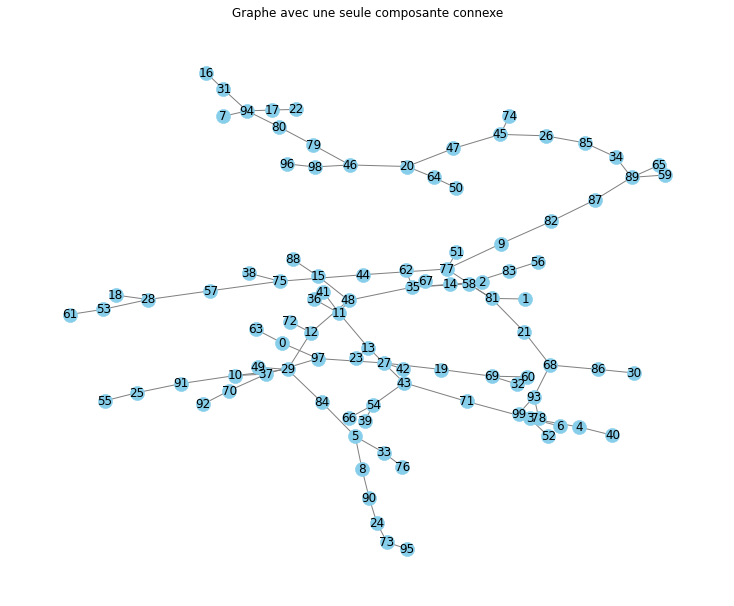

In [53]:


# Fixer la seed aléatoire pour la reproductibilité
random.seed(42)

# Nombre de nœuds souhaité
num_nodes = 100

# Création d'un arbre aléatoire avec num_nodes nœuds
G = nx.random_tree(num_nodes)

# Ajout d'arêtes supplémentaires pour créer une seule composante connexe
while not nx.is_connected(G):
    # Sélection aléatoire de deux nœuds
    src = random.choice(list(G.nodes))
    dst = random.choice(list(G.nodes))
    # Vérifier que les nœuds sélectionnés sont différents et qu'il n'y a pas déjà d'arête entre eux
    if src != dst and not G.has_edge(src, dst):
        # Ajouter l'arête
        G.add_edge(src, dst)

# Définir la disposition des nœuds pour un tracé plus esthétique
pos = nx.spring_layout(G)

# Tracer le graphe
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title("Graphe avec une seule composante connexe")
plt.show()




In [54]:
# Génération des étiquettes pour 70% des nœuds
num_labeled_nodes = int(0.7 * num_nodes)
labeled_nodes = random.sample(list(G.nodes), num_labeled_nodes)

# Génération aléatoire des étiquettes pour chaque nœud
labels = {}
for node in labeled_nodes:
    num_labels = random.randint(1, 10)  # Nombre aléatoire d'étiquettes pour chaque nœud (entre 1 et 10)
    node_labels = []
    for _ in range(num_labels):
        label = str(random.randint(1, 50))  # Génération d'une étiquette aléatoire entre "1" et "50"
        node_labels.append(label)
    labels[node] = node_labels
# Affichage des étiquettes
for node, node_labels in labels.items():
    print(f"Noeud {node}: {node_labels}")

Noeud 31: ['33', '7', '41']
Noeud 20: ['41', '33', '39', '13', '10']
Noeud 59: ['49', '11', '35', '50', '34', '1']
Noeud 48: ['21', '32', '2', '8', '24', '20', '16', '4', '16', '37']
Noeud 34: ['6', '47']
Noeud 81: ['5', '49', '35', '50', '9', '9', '43', '31']
Noeud 88: ['11', '17', '34', '39', '28', '14', '35', '49', '47']
Noeud 71: ['46', '20', '26', '43']
Noeud 28: ['29', '34', '29', '8', '16', '15']
Noeud 87: ['22', '2']
Noeud 41: ['36', '15', '38', '15', '1', '5', '46', '41', '4', '15']
Noeud 7: ['3', '22']
Noeud 29: ['33', '16']
Noeud 4: ['43', '32', '14', '35', '9']
Noeud 40: ['37', '31', '16', '31', '27', '13', '7', '7', '43', '28']
Noeud 51: ['28', '27', '30', '47', '4', '44']
Noeud 95: ['4', '26']
Noeud 8: ['7', '16', '13', '13', '35', '29']
Noeud 27: ['28', '12', '18']
Noeud 72: ['16', '5', '29', '36', '7', '4', '42', '35']
Noeud 85: ['6']
Noeud 94: ['11', '27', '32', '31']
Noeud 63: ['26', '4', '11', '25']
Noeud 50: ['25']
Noeud 58: ['30', '19', '28', '45', '47']
Noeud 18: 

In [55]:
# Convertir les étiquettes en vecteurs One-Hot Encoding
all_labels = set(label for node_labels in labels.values() for label in node_labels)
print("all_labels ",all_labels)
label_index_map = {label: i for i, label in enumerate(all_labels)}
total_label_count = len(all_labels)
one_hot_labels = {}
for node, node_labels in labels.items():
    one_hot_label = [0] * total_label_count
    for label in node_labels:
        one_hot_label[label_index_map[label]] = 1
    one_hot_labels[node] = one_hot_label

print("one_hot_labels ", one_hot_labels)

all_labels  {'37', '50', '47', '18', '21', '2', '4', '22', '46', '17', '5', '43', '26', '15', '30', '11', '14', '24', '8', '1', '25', '28', '3', '49', '40', '7', '42', '12', '35', '36', '41', '19', '29', '45', '13', '9', '16', '33', '23', '44', '38', '6', '34', '20', '39', '31', '27', '48', '10', '32'}
one_hot_labels  {31: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 20: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], 59: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 48: [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 34: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Classification

In [8]:
# Générer les embeddings de noeuds avec Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Obtenir les embeddings de noeuds appris
node_embeddings = model.wv


# Créer les caractéristiques X et les étiquettes y pour la classification
X = np.array([node_embeddings.get_vector(str(node)) for node in labeled_nodes])
y = np.array([one_hot_labels.get(node, [0] * total_label_count) for node in labeled_nodes])

print(X.shape , y.shape)
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du classificateur MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, activation='relu', solver='adam', random_state=42)

classifier.fit(X_train, y_train)

# Prédire les étiquettes pour les données de test
y_pred = classifier.predict(X_test)

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

(70, 64) (70, 50)
Accuracy: 0.0


/home/djeghali/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [96]:
print(len(y_pred ))
print((y))

14
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]


## Clustering

In [70]:
import hdbscan

# # Générer les embeddings de nœuds avec Node2Vec
# node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

# # Obtenir les embeddings de nœuds appris
# node_embeddings = model.wv

# Appliquer HDBSCAN sur les embeddings de nœuds
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)  # Spécifiez les paramètres appropriés
clusters = clusterer.fit_predict(node_embeddings.vectors)

# Afficher les clusters pour les 10 premiers nœuds
for node, cluster in zip(node_embeddings.index_to_key[:10], clusters[:10]):
    print(f"Noeud {node} : Cluster {cluster}")

Noeud 35 : Cluster 0
Noeud 3 : Cluster 0
Noeud 94 : Cluster 0
Noeud 89 : Cluster 0
Noeud 77 : Cluster 0
Noeud 48 : Cluster 0
Noeud 29 : Cluster 1
Noeud 11 : Cluster 0
Noeud 81 : Cluster 0
Noeud 69 : Cluster -1


### Grid search

In [71]:
import hdbscan
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Définir une fonction de score personnalisée utilisant silhouette_score
def hdbscan_silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    try:
        score = silhouette_score(X, labels)
    except ValueError:
        score = -1  # Si silhouette_score ne peut pas être calculé
    return score

# Paramètres à rechercher
param_grid = {
    'min_cluster_size': [3, 5, 10],
    'min_samples': [3, 5, 10]
}

# Création de l'objet HDBSCAN
clusterer = hdbscan.HDBSCAN()

# Création de l'objet GridSearchCV avec la fonction de score personnalisée
grid_search = GridSearchCV(clusterer, param_grid, cv=5, scoring=make_scorer(hdbscan_silhouette_score))

# Exécution de la recherche sur la grille
grid_search.fit(node_embeddings.vectors)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Obtention des clusters avec les meilleurs paramètres
best_clusterer = hdbscan.HDBSCAN(**grid_search.best_params_)
best_clusters = best_clusterer.fit_predict(node_embeddings.vectors)

# Affichage des clusters pour les 10 premiers nœuds
for node, cluster in zip(node_embeddings.index_to_key[:10], best_clusters[:10]):
    print(f"Noeud {node} : Cluster {cluster}")



/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anyes/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/anyes/.local/lib

Meilleurs paramètres trouvés : {'min_cluster_size': 3, 'min_samples': 3}
Noeud 35 : Cluster 4
Noeud 3 : Cluster 1
Noeud 94 : Cluster 0
Noeud 89 : Cluster 3
Noeud 77 : Cluster 6
Noeud 48 : Cluster -1
Noeud 29 : Cluster 2
Noeud 11 : Cluster 1
Noeud 81 : Cluster 5
Noeud 69 : Cluster 2


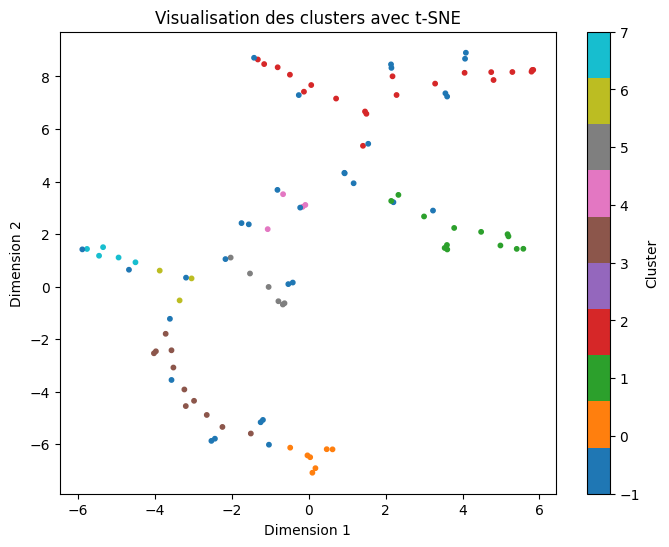

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(node_embeddings.vectors)

# Affichage des clusters avec un graphique de dispersion
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=best_clusters, cmap='tab10', s=10)
plt.colorbar(label='Cluster')
plt.title('Visualisation des clusters avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# GNN

In [87]:
subgraph = G.subgraph(labeled_nodes)
len(subgraph)

70

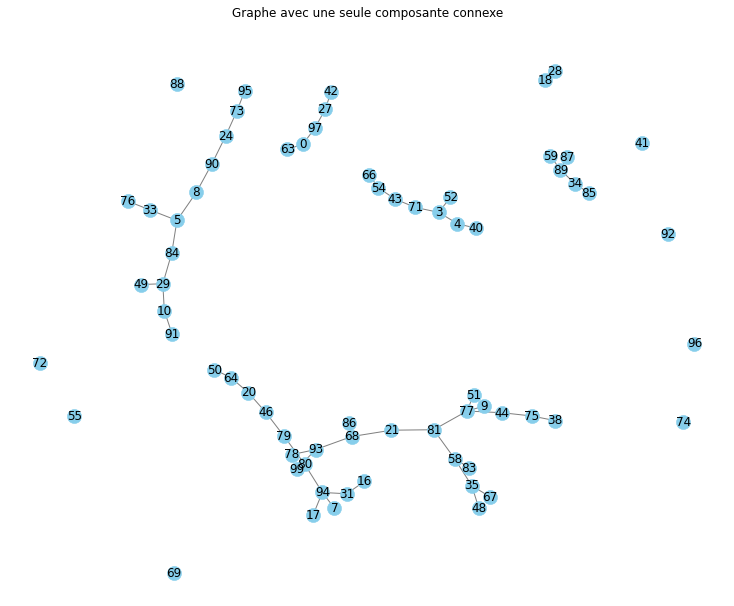

In [88]:
# Définir la disposition des nœuds pour un tracé plus esthétique
pos = nx.spring_layout(subgraph)

# Tracer le graphe
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=200, node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title("Graphe avec une seule composante connexe")
plt.show()

In [107]:
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# Définir un modèle de GNN simple avec une couche de convolution de graphe
class GNN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(GNN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, out_feats)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        return x


# Créer le modèle GNN
model = GNN(len(node_embeddings[0]), 64, len(y[0]))


print(len(list(all_labels)))
print(len(labeled_nodes))
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(labeled_nodes, y, test_size=0.2, random_state=42)


# Créer les caractéristiques X et les étiquettes y pour la classification
X_train_emb = np.array([node_embeddings.get_vector(str(node)) for node in X_train])
y_train_one_hot = y_train

X_test_emb = np.array([node_embeddings.get_vector(str(node)) for node in X_test])
y_test_one_hot = y_test

# Convertir les données en tenseurs PyTorch
X_tensor_train = torch.FloatTensor(X_train_emb)
y_tensor_train = torch.LongTensor(np.argmax(y_train_one_hot, axis=1))

# Convertir les données en tenseurs PyTorch
X_tensor_test = torch.FloatTensor(X_test_emb)
y_tensor_test = torch.LongTensor(np.argmax(y_test_one_hot, axis=1))


# Convertir le graphe en un objet DGLGraph
subgraph_train = G.subgraph(X_train)
dgl_graph_train = dgl.from_networkx(subgraph_train, node_attrs=None, edge_attrs=None)
dgl_graph_train = dgl.add_self_loop(dgl_graph_train)


# Convertir le graphe en un objet DGLGraph
subgraph_test = G.subgraph(X_test)
dgl_graph_test = dgl.from_networkx(subgraph_test, node_attrs=None, edge_attrs=None)
dgl_graph_test = dgl.add_self_loop(dgl_graph_test)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Entraîner le modèle
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    logits = model(dgl_graph_train, X_tensor_train)
    print(logits)
    print(y_tensor_train)
    y_pred_int = torch.argmax(logits, dim=1)
    print(y_pred_int)
    loss = criterion(logits, y_tensor_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Évaluation du modèle
model.eval()
logits = model(dgl_graph_test, X_tensor_test)
y_pred = torch.argmax(logits, dim=1)
accuracy = accuracy_score(y_tensor_test.numpy(), y_pred.numpy())
print(y_pred)
print("Accuracy:", accuracy)


50
70
tensor([[0.0000, 0.0140, 0.0886,  ..., 0.0000, 0.0710, 0.3024],
        [0.0000, 0.0000, 0.3070,  ..., 0.1209, 0.0274, 0.0610],
        [0.0000, 0.0000, 0.0904,  ..., 0.0000, 0.1028, 0.0000],
        ...,
        [0.0000, 0.3718, 0.5618,  ..., 0.0000, 0.0000, 0.1271],
        [0.0000, 0.0140, 0.0886,  ..., 0.0000, 0.0710, 0.3024],
        [0.0000, 0.0844, 0.1693,  ..., 0.0270, 0.1012, 0.1575]],
       grad_fn=<ReluBackward0>)
tensor([ 0,  0,  2,  9, 42,  5,  6, 16,  8, 10,  8,  5,  6, 17,  1,  6,  8,  3,
         6, 25, 11, 13,  0, 25, 13,  0,  2,  8,  4,  0,  1,  2,  6,  1,  4,  7,
         2,  2, 16,  7, 11,  7, 11,  9,  0, 10, 11, 30,  1, 15,  1, 20, 41,  4,
         0,  5])
tensor([ 7, 44, 22, 44, 22, 22, 44, 44, 45, 22, 39, 44, 45, 44, 39, 44, 44, 39,
        22, 20, 22, 44, 12, 44, 44, 44, 44, 44, 22, 44, 44, 44, 45, 20, 44, 44,
        45, 22, 44,  2, 44, 44, 44, 44, 22,  2, 22, 44, 44,  2, 46, 22, 44, 46,
         7, 46])
Epoch 1, Loss: 3.9271016120910645
tensor([[0.0000,

In [80]:
len(node_embeddings[0])

64

## GNN RACHA:

In [10]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#ensure that the PyTorch and the PyG are the same version
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.2.0+cu121


In [11]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [12]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [24]:
print(dataset[0])
print(dataset)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
KarateClub()


In [13]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
data.

In [31]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [35]:
print(data['y'])


tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [33]:
print(data['edge_index'])

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [28]:
print(data['x'])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


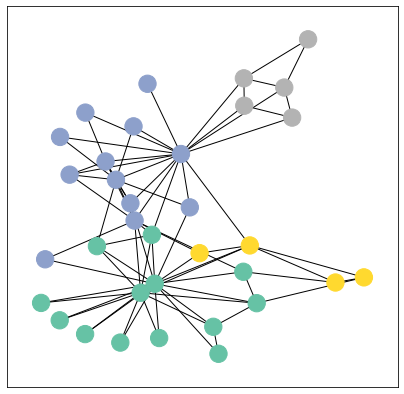

In [14]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [41]:
print(len(node_embeddings))

100


In [48]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(len(node_embeddings[0]), 64)
        self.conv2 = GCNConv(64, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, len(y[0]))

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=50, bias=True)
)


In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(node_embeddings, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')

lire sur GNN , chercher exemple
graph vite
comprendre comment fonctionne node2vec

In [73]:
print(len(data.x))
len(data.edge_index[0])

34


156